In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

def occlusion_sensitivity(model, X_val, y_val, feature_names=None, verbose=1, save_path=None):
    """
    Evaluates the importance of each input variable (sensor) based on the performance drop when resetting the variable.
    
    Args:
        model (.keras): Trained Keras Model (CNN1D or LSTM);
        X_val: Validation data in the format (samples, time window, sensors).
        y_val: True labels;
        feature_names: List with features/sensors names;
        verbose: Show the loop progress.
    
    Returns:
        List with the importance of each variable (the higher, the more relevant).    
    """
    baseline_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    importances = []

    for i in range(X_val.shape[2]):
        if verbose:
            print(f"Zerando variável {i+1}/{X_val.shape[2]}...")
        X_mod = X_val.copy()
        X_mod[:, :, i] = 0
        acc = model.evaluate(X_mod, y_val, verbose=0)[1]
        importances.append(baseline_acc - acc)

    if feature_names is None:
        feature_names = [f"Sensor {i+1}" for i in range(X_val.shape[2])]

    # Gráfico
    plt.figure(figsize=(14, 5))
    plt.bar(range(len(importances)), importances)
    plt.xticks(range(len(importances)), feature_names, rotation=90)
    plt.title("Occlusion Sensitivity - Importância das Variáveis")
    plt.ylabel("Queda na acurácia ao mascarar")
    plt.xlabel("Variáveis (Sensores)")
    plt.tight_layout()
    plt.grid(True)
    # 🔽 Se definido, salva o gráfico
    if save_path:
        plt.savefig(save_path)
        print(f"📁 Gráfico salvo em: {save_path}")
    plt.show()

    return importances


In [7]:

cnn1d_model_path = "../models/cnn1d_model.keras"
lstm_model_path = "../models/lstm_model.keras"

cnn1d_model = load_model(cnn1d_model_path)
lstm_model = load_model(lstm_model_path)

print("✅ Modelos carregados com sucesso!")

✅ Modelos carregados com sucesso!


In [25]:
# Val_dataset PATH
LSTM_val_set = "../data/processed/LSTM_val_dataset.csv"
CNN1D_val_set = "../data/processed/CNN1D_val_dataset.csv"

# Features
window_size = 30
n_sensors = 330
label_column = "target"

# load CSV
LSTM_df = pd.read_csv(LSTM_val_set)
CNN1D_df = pd.read_csv(CNN1D_val_set)

# split labels and features
LSTM_labels = LSTM_df[label_column].values
LSTM_features = LSTM_df.drop(columns=[label_column]).values
CNN1D_labels = LSTM_df[label_column].values
CNN1D_features = LSTM_df.drop(columns=[label_column]).values

# Reformat to (N, window, sensors)
LSTM_X_val = LSTM_features.reshape(-1, window_size, n_sensors)
LSTM_y_val = tf.keras.utils.to_categorical(labels, num_classes=3)
CNN1D_X_val = CNN1D_features.reshape(-1, window_size, n_sensors)
CNN1D_y_val = tf.keras.utils.to_categorical(labels, num_classes=3)

print(f"✅ Dados do LSTM carregados e reformatados: X_val.shape = {LSTM_X_val.shape}, y_val.shape = {LSTM_y_val.shape}")
print(f"✅ Dados do CNN1D carregados e reformatados: X_val.shape = {CNN1D_X_val.shape}, y_val.shape = {CNN1D_y_val.shape}")


✅ Dados do LSTM carregados e reformatados: X_val.shape = (4591, 30, 330), y_val.shape = (4591, 3)
✅ Dados do CNN1D carregados e reformatados: X_val.shape = (4591, 30, 330), y_val.shape = (4591, 3)


🔍 Avaliando importância das variáveis para CNN1D...
📁 Gráfico salvo em: ../results/CNN1D_featuresImportance.png


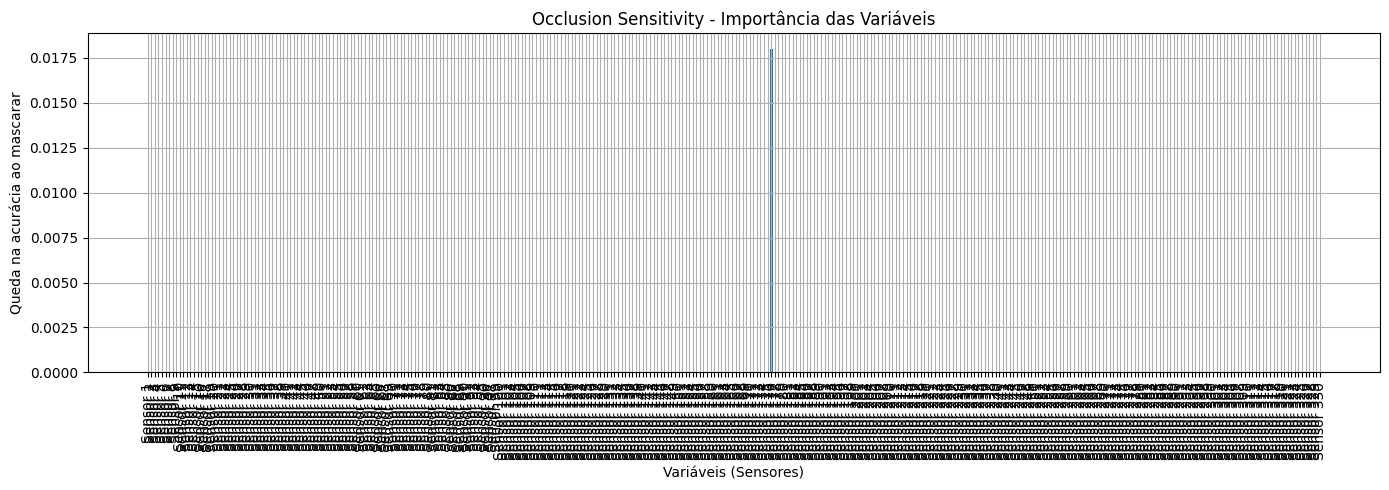

In [31]:
print("🔍 Avaliando importância das variáveis para CNN1D...")
cnn1d_importances = occlusion_sensitivity(
    model=cnn1d_model,
    X_val=CNN1D_X_val[:500],
    y_val=CNN1D_y_val[:500],
    feature_names=[f"Sensor {i+1}" for i in range(CNN1D_X_val.shape[2])],
    verbose=0,
    save_path="../results/CNN1D_featuresImportance.png"
)

🔍 Avaliando importância das variáveis para LSTM...
📁 Gráfico salvo em: ../results/LSTM_featuresImportance.png


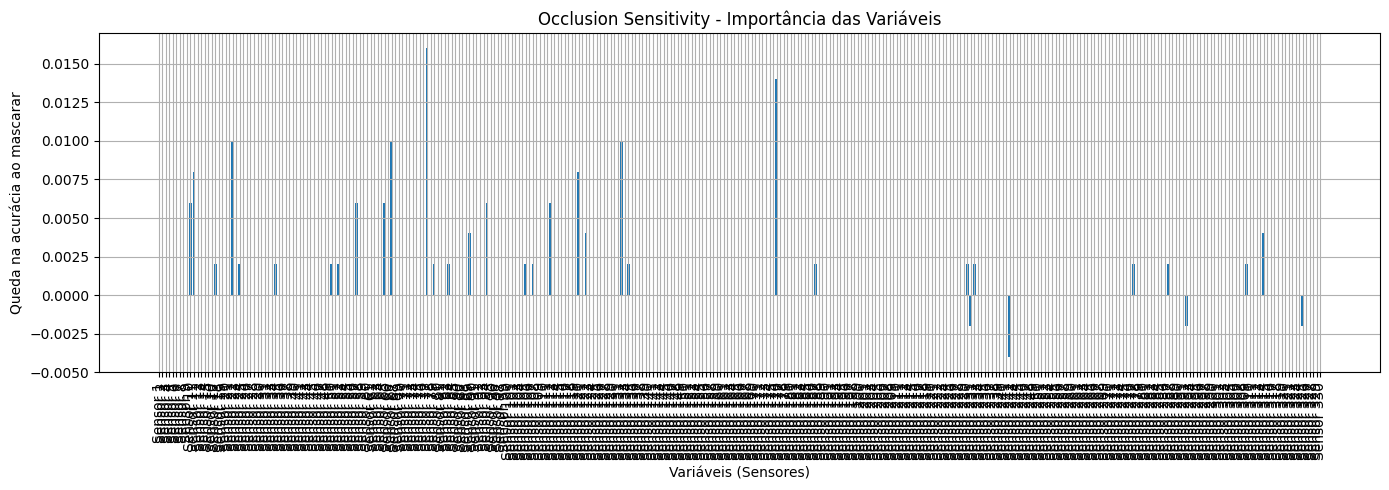

In [32]:
print("🔍 Avaliando importância das variáveis para LSTM...")
lstm_importances = occlusion_sensitivity(
    model=lstm_model,
    X_val=LSTM_X_val[:500],
    y_val=LSTM_y_val[:500],
    feature_names=[f"Sensor {i+1}" for i in range(LSTM_X_val.shape[2])],
    verbose=0,
    save_path="../results/LSTM_featuresImportance.png"
)

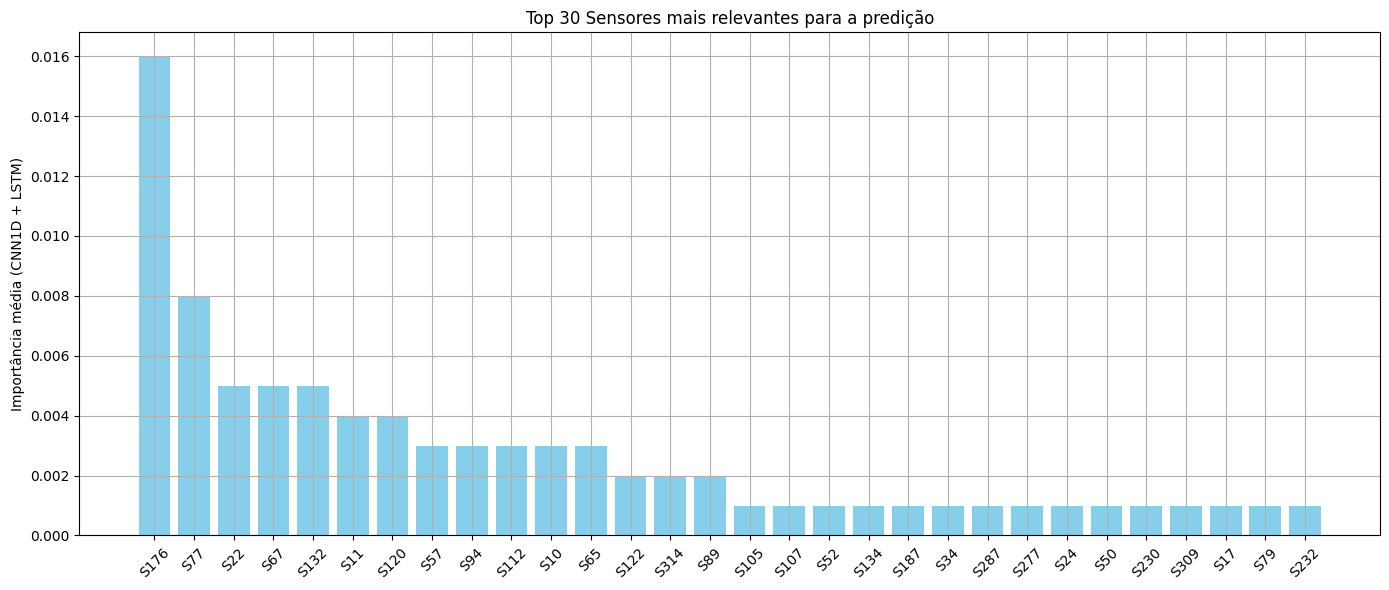

In [33]:

# Converter para arrays
cnn_arr = np.array(cnn1d_importances)
lstm_arr = np.array(lstm_importances)

# Calcular a média
avg_importance = (cnn_arr + lstm_arr) / 2

# Selecionar os 20 sensores mais importantes com base na média
top_k = 30
top_indices = np.argsort(avg_importance)[-top_k:][::-1]

# Plotar gráfico
indices = np.arange(top_k)
plt.figure(figsize=(14, 6))
plt.bar(indices, avg_importance[top_indices], color='skyblue')

plt.xticks(indices, [f"S{i+1}" for i in top_indices], rotation=45)
plt.ylabel("Importância média (CNN1D + LSTM)")
plt.title("Top 30 Sensores mais relevantes para a predição")
plt.grid(True)
plt.tight_layout()
fig_path = '../results/featuresImportance.png'
plt.savefig(fig_path)
plt.show()
